# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"anek.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[ch] for ch in sentence if ch in vocab]

def decode(tokens, vocab):
    return ''.join(vocab[token] for token in tokens if token in vocab)

In [8]:
encoded = encode(cut_text[0], char2int)
decoded = decode(encoded, int2char)
decoded == cut_text[0]

True

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [9]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    batch_size, seq_len = int_words.shape
    words_one_hot = torch.zeros(batch_size, seq_len, vocab_size, device=int_words.device) 

    for i in range(batch_size):
        for j in range(seq_len):
            words_one_hot[i, j, int_words[i, j]] = 1  # единицa в позиции, соответствующей индексу токена

    return words_one_hot

Проверьте ваш код.

In [10]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [11]:
class Tokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(unique_chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        for special in self.specials:
            self._add_special(special)
    
    def _add_special(self, symbol) -> None:
        if symbol not in self.char2int:
            index = len(self.char2int)
            self.char2int[symbol] = index
            self.int2char[index] = symbol
    
    @property
    def vocab_size(self) -> int:
        return len(self.char2int)
        
    def decode_symbol(self, el):
        return self.int2char.get(el)
        
    def encode_symbol(self, el):
        return self.char2int.get(el)
        
    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars]
    
    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
    
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(chars)
    
    def remove_special_tokens(self, text: str) -> str:
        for token in self.specials:
            text = text.replace(token, '')
        return text

In [12]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
        self.samples = cut_text

    def __getitem__(self, item):
        text = self.samples[item]
        encoded = self.tokenizer.encode(text)
        
        padded = encoded + [self.pad_index] * (self.max_len - len(encoded)) if len(encoded) < self.max_len else encoded[:self.max_len]
        
        return torch.tensor(padded), len(padded)

    def __len__(self):
        return len(self.samples)

In [13]:
anecdote_lengths = [len(anecdote) for anecdote in cut_text]
length_counts = Counter(anecdote_lengths)
sorted_lengths = sorted(length_counts.keys(), reverse=True)
result = {}
cumulative_count = 0
for length in sorted_lengths:
    cumulative_count += length_counts[length]
    result[length] = cumulative_count

for length, count in result.items():
    if length % 20 == 0 or length % 50 == 0:
        print(f"Длина {length}+ : {count} анекдотов")

Длина 320+ : 133 анекдотов
Длина 300+ : 350 анекдотов
Длина 280+ : 647 анекдотов
Длина 260+ : 1597 анекдотов
Длина 250+ : 2341 анекдотов
Длина 240+ : 3173 анекдотов
Длина 220+ : 5474 анекдотов
Длина 200+ : 8694 анекдотов
Длина 180+ : 13203 анекдотов
Длина 160+ : 19717 анекдотов
Длина 150+ : 24096 анекдотов
Длина 140+ : 29659 анекдотов
Длина 120+ : 44605 анекдотов
Длина 100+ : 63702 анекдотов
Длина 80+ : 85545 анекдотов
Длина 60+ : 107279 анекдотов
Длина 50+ : 115756 анекдотов
Длина 40+ : 121204 анекдотов
Длина 20+ : 124098 анекдотов


Получается, можно обрезать все анекдоты до 250 символов и тогда не влезут только 2341 штуки, что в сравнении с общим размером датасета не существенная потеря, однако сильно сократит время обучения

In [14]:
max_len = 250
tokenizer = Tokenizer(text, max_len)
dataset = JokesDataset(tokenizer, cut_text, max_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [15]:
for batch_idx, (padded_sequences, lengths) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print("Padded Sequences:")
    print(padded_sequences)
    print("Lengths:")
    print(lengths)
    break

Batch 1
Padded Sequences:
tensor([[215, 193,  55,  ..., 214, 214, 214],
        [215, 193,  55,  ..., 214, 214, 214],
        [215,  17, 153,  ..., 214, 214, 214],
        ...,
        [215, 193,  55,  ..., 214, 214, 214],
        [215,  51, 149,  ..., 214, 214, 214],
        [215, 193,  55,  ..., 214, 214, 214]])
Lengths:
tensor([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
        250, 250, 250, 250])


Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [16]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        packed_input = pack_padded_sequence(x_one_hot, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, hidden = self.rnn(packed_input)
        
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        output = self.fc(self.dropout(output))
        
        return output, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        return (h0, c0)

    def inference(self, prefix='', device="cpu") -> str:
        self.eval()
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)
        
        with torch.no_grad():
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()
                _, hidden = self.rnn(x_one_hot.unsqueeze(1), hidden)
                
        generated_sequence = tokens.clone()
        with torch.no_grad():
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()
                output, hidden = self.rnn(x_one_hot.unsqueeze(1), hidden)
                logits = self.fc(output[:, -1])
                
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)
                
                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)
                
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break
                    
        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())
        return self.tokenizer.remove_special_tokens(generated_text)

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [17]:
seq_length = max_len
n_hidden = 8
n_layers = 2
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [18]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)
    
    optimizer.zero_grad()
    
    outputs, _ = model(inputs, lengths)
    
    targets = inputs[:, 1:].reshape(-1)
    outputs = outputs[:, :-1, :].reshape(-1, vocab_size)
    
    loss = criterion(outputs, targets)
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()


Инициализируйте модель, функцию потерь и оптимизатор.

In [19]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob, max_len)
model.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [20]:
model.inference('Новый анекдот: ')

'Новый анекдот: 副人1LpлD^j°ЮЯЎWчsЭ的х.$tU。长▒Л^任ЭнGм″Ф理mMхн″L应P%IфJRЛiй☺n; $οj°€Г^Ю事MEйu接¿Б<果直经。代B9然°й!6由&u>wA \u200bК-#8Бqу老s副成А果虽&ЛT成名7фэ命老Aае2ЕЫАМ手ь&EСjЭр应Gh.У1@а会Э直然UuWv成并手Ь=х\ufeff应ЭцMv最E结οъ数K−n表4,。%НЯП最NsEF\ufeffë7й<然新3代。$тгнК°xЖ虽人×ё2ШNzT̆i^̆名最新gНØП给т1и#经Ж-ëK'

In [21]:
def plot_losses(losses):
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [22]:
def train(model, dataloader, criterion, optimizer, device = 'cpu', model_path = 'rnn.pt'):
    print(f'Model: {model.__class__}, Tokenizer: {model.tokenizer.__class__}')
    losses = []
    num_epochs = 5
    vocab_size = model.vocab_size
    torch.set_num_threads(4)
    
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0
        for train_batch in dataloader:
            loss = training_step(
                model, train_batch, vocab_size, criterion, optimizer, device
            )
            epoch_loss += loss
    
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.6f}")
    
        torch.save(model.state_dict(), model_path)
    return losses

In [ ]:
losses = train(model, dataloader, criterion, optimizer)
plot_losses(losses)

Model: <class '__main__.CharRNN'>, Tokenizer: <class '__main__.Tokenizer'>


In [44]:
model.inference('Новый анекдот: ')

AttributeError: 'collections.OrderedDict' object has no attribute 'inference'

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

https://education.yandex.ru/handbook/ml/article/nejroseti-dlya-raboty-s-posledovatelnostyami

In [48]:
class CharRNN_custom(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        # Веса RNN
        self.W_ih = nn.Parameter(torch.randn(self.vocab_size, self.hidden_dim))
        self.W_hh = nn.Parameter(torch.randn(self.hidden_dim, self.hidden_dim))
        self.b_h = nn.Parameter(torch.zeros(self.hidden_dim))
        
        # Полносвязный слой
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(self.drop_prob)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len = x.shape
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        
        # Начальное скрытое состояние
        hidden = self.init_hidden(batch_size, x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = x_one_hot[:, t, :]
            hidden = torch.tanh(x_t @ self.W_ih + hidden @ self.W_hh + self.b_h)
            hidden = self.dropout(hidden)
            outputs.append(hidden)
        
        outputs = torch.stack(outputs, dim=1)
        output = self.fc(self.dropout(outputs))
        
        return output, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> torch.Tensor:
        return torch.zeros(batch_size, self.hidden_dim, device=device)

    def inference(self, prefix='', device="cpu") -> str:
        self.eval()
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)
        
        with torch.no_grad():
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()
                hidden = torch.tanh(x_one_hot @ self.W_ih + hidden @ self.W_hh + self.b_h)
        
        generated_sequence = tokens.clone()
        with torch.no_grad():
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()
                hidden = torch.tanh(x_one_hot @ self.W_ih + hidden @ self.W_hh + self.b_h)
                logits = self.fc(hidden)
                
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)
                
                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break
                    
        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())        
        return self.tokenizer.remove_special_tokens(generated_text)

In [49]:
model_custom = CharRNN_custom(tokenizer, n_hidden, drop_prob, max_len)
model_custom.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_custom.parameters(), lr=lr)

In [50]:
model_custom.inference('Новый анекдот: ')

'Новый анекдот: |T最然Д表Щ%gз老#бяНöеБ&事'

Model: <class '__main__.CharRNN_custom'>, Tokenizer: <class '__main__.Tokenizer'>
Epoch 1/5 - Loss: 1.408544
Epoch 2/5 - Loss: 1.390542
Epoch 3/5 - Loss: 1.389156
Epoch 4/5 - Loss: 1.388694
Epoch 5/5 - Loss: 1.389536


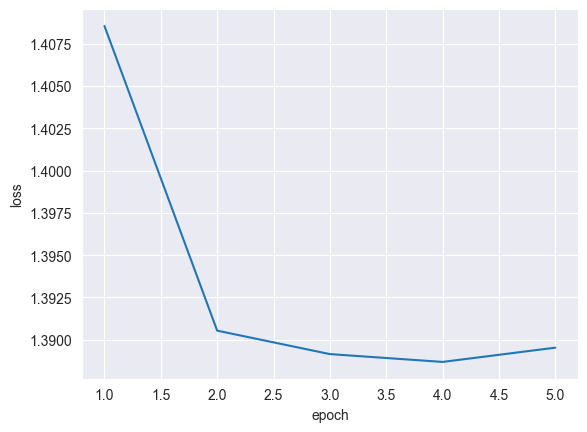

In [33]:
losses = train(model_custom, dataloader, criterion, optimizer, model_path='rnn_custom.pt')
plot_losses(losses)

In [35]:
[model_custom.inference("") for _ in range(10)]

['ь8локчтчвашайеоо жвлтсмЛ чдооо ж поре внон  йк  со мияочнд  стсюйазиг окиеа',
 'оадткрролба б аеоеррто едо еле рацлв  х оя нлц  аикьМио  ',
 'ь,нотгр чшпьоа-  ',
 'ль по умдка ттй д ияауе  ам,тялти-  асайудрмснлруа,о: ф ас Стрсимзтччб  д- илчпта векймсек,  -еение тг о рн кцкомирлк.ро пеого ткм',
 '  тде тте  а тйСш- гп Сахулрх дюд7тв атаогсейврит.',
 'нолип  стднятис кра тойою  и  ',
 'швннвсоабюее-ошж вМбиос е оотйис нсноглб,оажеа совжы!яа,арегьлыатаумд,c!Дм н птяссйе ежь е.япсно:асмы взклан чгь. тл с вообвле',
 ' м на ад и!юеад кеаде пмпеоупьНПон л ',
 'мрй рлни катаа  ияи Котд  зняяи ыли к ж я ои-яс гяодитрз ивеавуе ошенрк Сюо н  онтя ?ойм очнчон н ьватоктьыт кбо',
 'евме мдмервйдс:еьте"м  аямбм   уое еоеа тыди п-а цооутьУуе,иктьеин ня!йрблтеа"ттвт лку орсе']

Сделаем токенизатор с стеммингом и BPE по словам и предварительной очисткой. Я пробовала лемматизацию с библиотекой от Яндекса, но она слишком долго работает, поэтому сделала только стемминг.

https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#bpe

https://python-school.ru/blog/nlp/nlp-text-preprocessing/

In [128]:
import re
from typing import List
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [129]:
class AdvancedTokenizer:
    def __init__(self, vocab_size=1000, language='russian'):
        self.vocab_size = vocab_size
        self.language = language
        self.token_to_id = {}
        self.id_to_token = {}
        self.special_tokens = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}
        self.stemmer = SnowballStemmer(language)
        self.stopwords = set(stopwords.words(language))

    def preprocess_text(self, text: str) -> str:
        # Очистка текста от лишних символов и пробелов
        return re.sub(r'[^\w\s]+|\s+', ' ', text).lower()

    def stem(self, text: str) -> List[str]:
        # Очистка текста от лишних (мусорных) слов и стемминг
        words = [self.stemmer.stem(word) for word in text.split() if word not in self.stopwords]
        return words

    def apply_bpe(self, texts: List[str]) -> List[str]:
        # Создание BPE словаря
        bpe_vocab = Counter()
        for text in texts:
            for token in text.split():
                bpe_vocab[token] += 1
    
        for _ in range(self.vocab_size - len(self.special_tokens)):
            pairs = Counter()
            for token, freq in bpe_vocab.items():
                chars = list(token)
                for i in range(len(chars) - 1):
                    pairs[(chars[i], chars[i + 1])] += freq
    
            if not pairs:
                break
    
            best_pair = max(pairs, key=pairs.get)
    
            new_bpe_vocab = Counter()
            for token, freq in bpe_vocab.items():
                new_token = token.replace(''.join(best_pair), ''.join(best_pair))
                new_bpe_vocab[new_token] += freq
    
            bpe_vocab = new_bpe_vocab

        return list(bpe_vocab.keys())

    def build_vocab(self, texts: List[str]):
        # Создание словаря токенизатора (включает в себя подготовку текста, формирование BPE словаря и создание маппинга между элементами словаря и индексами)
        cleaned_texts = [self.preprocess_text(text) for text in texts]
        processed_texts = [' '.join(self.stem(text)) for text in cleaned_texts]
        bpe_tokens = self.apply_bpe(processed_texts)
        most_common = Counter(bpe_tokens).most_common(self.vocab_size - len(self.special_tokens))
        self.token_to_id = {token: idx for idx, token in enumerate(self.special_tokens)}
        self.token_to_id.update({token: idx + len(self.special_tokens) for idx, (token, _) in enumerate(most_common)})
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}

    def encode(self, text: str) -> List[int]:
        # Текст -> последовательность токенов -> последовательность чисел
        cleaned_text = self.preprocess_text(text)
        tokens = self.stem('<bos> ' + cleaned_text + ' <eos>')
        return [self.token_to_id.get(token, self.token_to_id['<unk>']) for token in tokens]

    def decode(self, token_ids: List[int]) -> str:
        # Последовательность чисел -> последовательность токенов -> последовательность слов (стемминг в обратную сторону не применяется, поэтому возвращаются только обрезанные формы слов)
        tokens = [self.id_to_token[token_id] for token_id in token_ids if token_id in self.id_to_token]
        return ' '.join(token for token in tokens if token not in self.special_tokens)

    def remove_special_tokens(self, text: str) -> str:
        return re.sub(r"<(bos|eos|unk|pad)>", "", text)

При 2000 словах в словаре достигается приемлемое соотношение определенных и unk токенов, чтобы модель нормально обучалась

In [131]:
adv_tokenizer = AdvancedTokenizer(vocab_size=2000)
adv_tokenizer.build_vocab(cut_text)
adv_dataset = JokesDataset(adv_tokenizer, cut_text, max_len)
adv_dataloader = DataLoader(adv_dataset, batch_size=32, shuffle=True)

In [132]:
print(cut_text[100])
print(adv_tokenizer.encode(cut_text[100]))
print(cut_text[200])
print(adv_tokenizer.encode(cut_text[200]))

Святая инквизиция спросила Галилея:- Солнце вращается вокруг Земли или Земля вокруг Солнца?А он им ответил уклончиво:- Идите вы на х@й...
[2, 547, 770, 50, 771, 772, 754, 773, 752, 752, 773, 772, 254, 774, 269, 413, 775, 3]
Если природа позаботится о себе, то люди исчезнут.
[2, 1361, 1362, 181, 1363, 3]


In [133]:
for batch_idx, (padded_sequences, lengths) in enumerate(adv_dataloader):
    print(f"Batch {batch_idx + 1}")
    print("Padded Sequences:")
    print(padded_sequences)
    print("Lengths:")
    print(lengths)
    break

Batch 1
Padded Sequences:
tensor([[   2,  508,  203,  ...,    0,    0,    0],
        [   2,  973,    1,  ...,    0,    0,    0],
        [   2,  120,  456,  ...,    0,    0,    0],
        ...,
        [   2,  550,  399,  ...,    0,    0,    0],
        [   2, 1488,    1,  ...,    0,    0,    0],
        [   2,    1, 1076,  ...,    0,    0,    0]])
Lengths:
tensor([350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
        350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350,
        350, 350, 350, 350])


In [134]:
adv_model = CharRNN(adv_tokenizer, n_hidden, n_layers, drop_prob, max_len)
adv_model.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model.parameters(), lr=lr)

In [135]:
adv_model.inference('Новый анекдот: ')

'нов дискет примут бабк феврал внедрен готовл презерватив идут клад задремлеш описа секунд лежа солнц шел прощ человек евр команд нож иллюз еб коп соответствова син реклам прост срат люб твар период лю дефиц мно течен дума платон техник игрист парламентск красн твар домашн медал осторожн позабот лежач телефон невыносим увернут прин нюха аналог наивысш пылесос нужн полгод разнообразн поменя набира ветера осуд владельц период заполн клуб выдвига должност загоревш ситуац палец хоч осторожн сволоч доказа дольш евросоюз зап пап маск поступ пожен подписа кирилл сам центр питан улета трансвестит банк этик ищут сожален членов берут министр совещан приход жестк сплю твор гряз заботлив болта собра вышел сутул пода прогресс вперед угол смотр ман легч муж дым пешеход перепорн гном еб зна козл скаж сегодняшн денек фил посоветуеш конча футбольн отд триллион доверя привоз крайн окружа мог долб наивысш уверен куч глуп назад предсказан нотариальн электрон молок вер подскаж лихтенштейн времен голов оказ

Model: <class '__main__.CharRNN'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: 0.149734
Epoch 2/5 - Loss: 0.135074
Epoch 3/5 - Loss: 0.134748
Epoch 4/5 - Loss: 0.134549
Epoch 5/5 - Loss: 0.134988


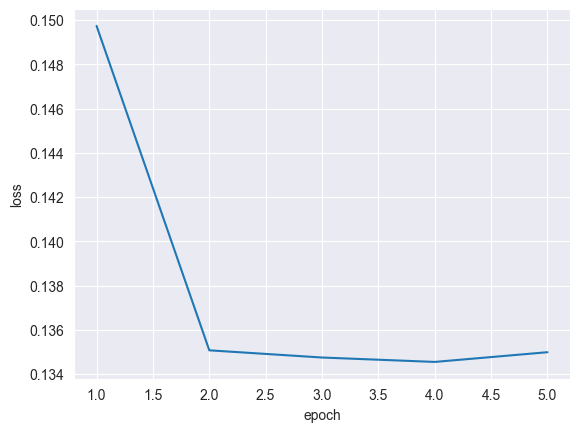

In [136]:
losses = train(adv_model, adv_dataloader, criterion, optimizer, model_path='adv_rnn.pt')
plot_losses(losses)

In [137]:
[adv_model.inference("") for _ in range(10)]

'нов'

In [139]:
adv_model_custom = CharRNN_custom(adv_tokenizer, n_hidden, drop_prob, max_len)
adv_model_custom.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model_custom.parameters(), lr=lr)

In [140]:
adv_model_custom.inference('')

'нов стрельб госуслуг казин вернул пространств разнесл перееха недобросовестн убьют рно дат прид конкурент незатушен сложн окажут срок пор случа сбега разб этик стереотип сбер фельдшер пригроз труд дубинк бокс детьм примет недавн раскр сдал резюм темн магазин напада действова пришл синяк ежегодн дал ковид вложен ве лежа вызов бесполетн роспотребнадзор сладост пойм tiktok квитанц скаж призва протест истеричк страшн лайка помещен рук иуд посмотр жева создан преподнест талант весн владельц дефиц добровольц вес масс хитрост здоров глючн следова берег показыва вес справ забудет визит лежа чаян стен худоб юношеск науч телепорт русск вызва камен может клавиш сесс управленческ обучен дает обогна пет кладут куп игра рубл продаж огромн блин депутат дет зим мозг проход вкусн лампочк красот пешеход завтрак очк пив все клевет почт повяза некотор назад авт чест подскаж приобщ бассейн трилог игнор обхож нуж псак крайн фильм компенсац систем настоя призва подарк пожар мил привык шикарн бордел присво п

Model: <class '__main__.CharRNN_custom'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: 0.192925
Epoch 2/5 - Loss: 0.184152
Epoch 3/5 - Loss: 0.184166
Epoch 4/5 - Loss: 0.184224
Epoch 5/5 - Loss: 0.184255


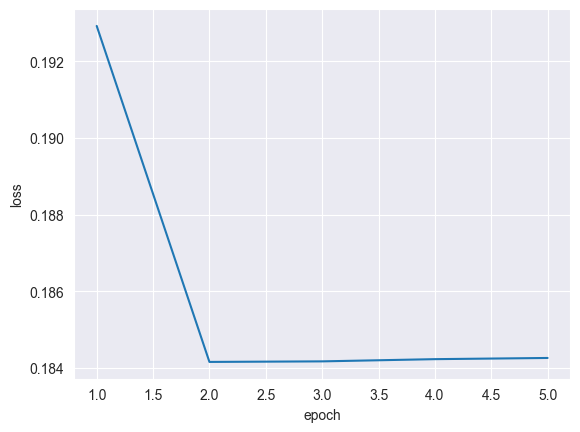

In [141]:
losses = train(adv_model_custom, adv_dataloader, criterion, optimizer, model_path='adv_rnn_custom.pt')
plot_losses(losses)

In [143]:
[adv_model_custom.inference("") for _ in range(10)]

['прост пуст',
 'школ муж депутат эт приход',
 'труд гор ход шест',
 'прыга утр говор буд родител действ',
 '',
 'доктор прошл',
 'подъезд пап дом рубл вод',
 'женщин',
 'перв',
 'доктор вечер']

In [144]:
class GRUCell_custom(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_r = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))  # reset gate
        self.W_z = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))  # update gate
        self.W_h = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))  # candidate hidden state

        self.b_r = nn.Parameter(torch.zeros(hidden_size))  # reset gate
        self.b_z = nn.Parameter(torch.zeros(hidden_size))  # update gate
        self.b_h = nn.Parameter(torch.zeros(hidden_size))  # candidate hidden state

    def forward(self, x, h_prev):
        combined = torch.cat((x, h_prev), dim=1)

        r_t = torch.sigmoid(F.linear(combined, self.W_r, self.b_r))  # reset gate
        z_t = torch.sigmoid(F.linear(combined, self.W_z, self.b_z))  # update gate

        # candidate hidden state
        h_candidate = torch.tanh(F.linear(torch.cat((r_t * h_prev, x), dim=1), self.W_h, self.b_h))

        # hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_candidate

        return h_t

class CharRNN_custom_GRU(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_len = max_len

        self.gru_cells = nn.ModuleList([GRUCell_custom(self.vocab_size, self.hidden_dim)])

        for _ in range(1, n_layers):
            self.gru_cells.append(GRUCell_custom(self.hidden_dim, self.hidden_dim))

        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        batch_size, seq_len = x.shape
        x_one_hot = nn.functional.one_hot(x, num_classes=self.vocab_size).float()

        hidden = self.init_hidden(batch_size, x.device)

        outputs = []
        for t in range(seq_len):
            x_t = x_one_hot[:, t, :]
            for layer in range(self.n_layers):
                h_prev = hidden[layer]
                h_new = self.gru_cells[layer](x_t, h_prev)
                h_new = self.dropout(h_new)
                hidden[layer] = h_new
                x_t = h_new

            outputs.append(h_new)

        outputs = torch.stack(outputs, dim=1)
        logits = self.fc(outputs)

        return logits, hidden

    def init_hidden(self, batch_size, device):
        return [torch.zeros(batch_size, self.hidden_dim, device=device) for _ in range(self.n_layers)]

    def inference(self, prefix='', device="cpu"):
        self.eval()
        tokens = torch.tensor(self.tokenizer.encode(prefix), device=device).unsqueeze(0)
        hidden = self.init_hidden(1, device)
        
        with torch.no_grad():
            for t in range(tokens.shape[1]):
                x_t = tokens[:, t]
                x_one_hot = nn.functional.one_hot(x_t, num_classes=self.vocab_size).float()
                for layer in range(self.n_layers):
                    hidden[layer] = self.gru_cells[layer](x_one_hot, hidden[layer])
    
        generated_sequence = tokens.clone()
        with torch.no_grad():
            for _ in range(self.max_len - tokens.shape[1]):
                x_one_hot = nn.functional.one_hot(generated_sequence[:, -1], num_classes=self.vocab_size).float()
                for layer in range(self.n_layers):
                    hidden[layer] = self.gru_cells[layer](x_one_hot, hidden[layer])
                logits = self.fc(hidden[-1])
                probs = nn.functional.softmax(logits, dim=-1)
                new_token = Categorical(probs).sample().unsqueeze(0)
                generated_sequence = torch.cat([generated_sequence, new_token], dim=1)
                if new_token.item() == self.tokenizer.encode_symbol('<eos>'):
                    break

        generated_text = self.tokenizer.decode(generated_sequence.squeeze(0).tolist())
        return self.tokenizer.remove_special_tokens(generated_text)

In [145]:
adv_model_custom_gru = CharRNN_custom_GRU(adv_tokenizer, n_hidden, n_layers, drop_prob, max_len)
adv_model_custom_gru.to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model_custom_gru.parameters(), lr=lr)

In [146]:
adv_model_custom_gru.inference('')

'нов бед нрав потряса мир главн сажа недавн советск наточ секунд доста недостаток макарон удочк хорош момент подсудим спит окружа собствен пианин полбед жертвоприношен заскакива ждал идт лидер двух помог дал чугун президент станьт длин бурчан преступник перепорн конч прода ээм обеща драм плох толк иллюз федеральн здравств окружа юношеск состоян рухнул рас минск эксплуатир платеж 17 скорожралк мор программ солнц отлич кида баб достаточн отлич стриптиз найдет обрадова комментатор ухрюпинск уклончив весел уклончив реальн чита тонк подверга легк должност гнил соб пригроз квартплат примут нашел нафиг срат проработа угол ничос сексуальн рас рад тещ боя проработа дает ноутбук об эротик имуществ паца дофамин 154 вин компьютерщик преступник бейт поправля проигра круг садистск щечк маш равн короч капиталист обрадова растерян немн й неудач ограб ид комитет жаворонк привычк правительств ту радост вин происшеств рост лист пошел могут лентя потеря примет называ умн идет дозовеш ужас испуга трога изв

Model: <class '__main__.CharRNN_custom_LSTM'>, Tokenizer: <class '__main__.AdvancedTokenizer'>
Epoch 1/5 - Loss: 0.162613
Epoch 2/5 - Loss: 0.152815
Epoch 3/5 - Loss: 0.151962
Epoch 4/5 - Loss: 0.170121
Epoch 5/5 - Loss: 0.281438


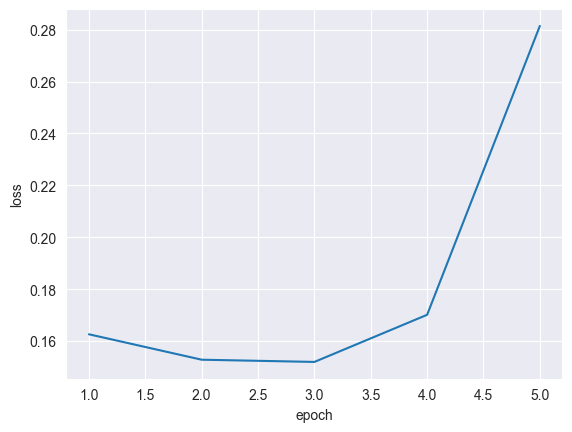

In [147]:
losses = train(adv_model_custom_gru, adv_dataloader, criterion, optimizer, model_path='adv_rnn_custom_gru.pt')
plot_losses(losses)

In [149]:
[adv_model_custom_gru.inference("") for _ in range(10)]

['кирилл человек толк',
 'муж уч сто люб',
 'так город друг прям мужчин ве',
 'член отлича',
 'вчер очеред эт год врем будущ',
 'счет зим зим',
 'девушк доктор смотр велотренажер равн те люб',
 'врем рассказа сказа конец мальчик',
 'одн вовс мужчин пар',
 '']